# Setup Environment

In [1]:
#@title Mount your Google Drive
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#@title Install dependencies
!pip install numpy==1.21.6 imageio==2.9.0 matplotlib==3.2.2

ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement numpy==1.21.6 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 1.13.3, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5, 1.20.0, 1.20.1, 1.20.2, 1.20.3, 1.21.0, 1.21.1, 1.22.0, 1.22.1, 1.22.2, 1.22.3, 1.22.4, 1.23.0, 1.23.1, 1.23.2, 1.23.3, 1.23

In [4]:
%cd $SYM_PATH
if not os.path.exists("Dropout_BatchNorm_VanillaNumpy"):
  !git clone https://github.com/fadibenz/BatchNorm-Dropout-VanillaNumpy
%cd BatchNorm-Dropout-VanillaNumpy

/content/gdrive/My Drive/Dropout_BatchNorm_VanillaNumpy
fatal: destination path 'BatchNorm-Dropout-VanillaNumpy' already exists and is not an empty directory.
/content/gdrive/My Drive/Dropout_BatchNorm_VanillaNumpy/BatchNorm-Dropout-VanillaNumpy


In [5]:
#@title Download datasets
%cd deeplearning/datasets/
!bash ./get_datasets.sh
%cd ../..

/content/gdrive/My Drive/Dropout_BatchNorm_VanillaNumpy/BatchNorm-Dropout-VanillaNumpy/deeplearning/datasets
--2025-02-02 13:32:28--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  24.2MB/s    in 6.7s    

2025-02-02 13:32:35 (24.2 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content/gdrive/My Drive/Dropout_BatchNorm_VanillaNumpy/BatchNorm-Dropout-Vanil

In [6]:
#@title Configure Jupyter Notebook
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Batch Normalization
Implementation of Batch Normalization in Vanilla Numpy. 

In [29]:
# As usual, a bit of setup

import os
import time
import numpy as np
import matplotlib.pyplot as plt
from deeplearning.classifiers.fc_net import *
from deeplearning.data_utils import get_CIFAR10_data
from deeplearning.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from deeplearning.solver import Solver
import random
import torch
seed = 7
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

os.makedirs("submission_logs", exist_ok=True)

def abs_error(x, y):
    return np.max(np.abs(x - y))

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [30]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
    print ('%s: ' % k, v.shape)

deeplearning/datasets/cifar-10-batches-py/data_batch_1
deeplearning/datasets/cifar-10-batches-py/data_batch_2
deeplearning/datasets/cifar-10-batches-py/data_batch_3
deeplearning/datasets/cifar-10-batches-py/data_batch_4
deeplearning/datasets/cifar-10-batches-py/data_batch_5
deeplearning/datasets/cifar-10-batches-py/test_batch
X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


In a Fully Connected Network, the forward propagation during training given input $\mathbf{X}\in\mathbb{R}^{n,d}$ is defined as:

$$\begin{aligned}
\mu_j &= \dfrac1n \sum_{i=1}^n X_{i,j} \\
\sigma^2_j &= \dfrac{1}{n} \sum_{i=1}^n (X_{i,j} - \mu_j)^2 \\
Y_{i,j} &= \mathrm{BN}(\mathbf{X}|\gamma, \beta)_{i,j} = \dfrac{X_{i,j} - \mu_j}{\sqrt{\sigma^2_j + \epsilon}}\gamma_j + \beta_j
\end{aligned}$$

It would be helpful if you introduce another intermediate variable $\mathbf{Z}\in\mathbb{R}^{n,d}$:

$$\begin{aligned}
\mu_j &= \dfrac1n \sum_{i=1}^n X_{i,j} \\
\sigma^2_j &= \dfrac{1}{n} \sum_{i=1}^n (X_{i,j} - \mu_j)^2 \\
Z_{i,j} &= \dfrac{X_{i,j} - \mu_j}{\sqrt{\sigma^2_j + \epsilon}} \\
Y_{i,j} &= \mathrm{BN}(\mathbf{X}|\gamma, \beta)_{i,j} = Z_{i,j}\gamma_j + \beta_j
\end{aligned}$$ [link text](https://)



## Batch normalization: Forward

Implementation can be found in the file `deeplearning/layers.py`.
The following cell tests  implementation.

In [9]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

# Simulate the forward pass for a two-layer network
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print ('Before batch normalization:')
print ('  means: ', a.mean(axis=0))
print ('  stds: ', a.std(axis=0))

# Means should be close to zero and stds close to one
print ('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print ('  mean: ', a_norm.mean(axis=0))  # expected: (approx.) [0, 0, 0]
print ('  std: ', a_norm.std(axis=0))  # expected: (approx.) [1, 1, 1]

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print ('After batch normalization (nontrivial gamma, beta)')
print ('  means: ', a_norm.mean(axis=0))  # expected: (approx.) [11, 12, 13]
print ('  stds: ', a_norm.std(axis=0))  # expected: (approx.) [1, 2, 3]

Before batch normalization:
  means:  [-33.90168215  18.46269328  -7.49068667]
  stds:  [38.72112268 29.39668975 31.14272252]
After batch normalization (gamma=1, beta=0)
  mean:  [ 4.62963001e-16  8.99280650e-17 -1.38777878e-17]
  std:  [1.         0.99999999 0.99999999]
After batch normalization (nontrivial gamma, beta)
  means:  [11. 12. 13.]
  stds:  [1.         1.99999999 2.99999998]


In [10]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.
N, D1, D2, D3 = 200, 50, 60, 3
np.random.seed(seed)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in range(50):
    X = np.random.randn(N, D1)
    a = np.maximum(0, X.dot(W1)).dot(W2)
    batchnorm_forward(a, gamma, beta, bn_param)
bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print ('After batch normalization (test-time):')
print ('  means: ', a_norm.mean(axis=0))
print ('  stds: ', a_norm.std(axis=0))
expected_a_norm = np.array(
    [[-7.37859885e-01,  2.10050591e+00, -3.24286480e-01],
    [ 2.02781031e+00,  1.92492178e-01,  1.54852388e+00],
    [ 5.44242949e-01,  1.07389911e+00,  8.06464618e-01],
    [-2.25599789e-02,  7.64501325e-01, -3.03045313e-01],
    [-9.74592587e-01,  6.01731799e-01, -6.57200019e-03]])
print ('Abs error of a_norm: ', abs_error(a_norm[:5, :], expected_a_norm))

After batch normalization (test-time):
  means:  [-0.00967681  0.01315673  0.00748036]
  stds:  [1.07009997 1.01651564 0.88995918]
Abs error of a_norm:  4.3424073226105975e-09


## Batch Normalization: backward
Implementation can be found in the file `deeplearning/layers.py`.
The following cell tests the implementation. I derived the gradients in paper and then coded this part (In contrast with the backpropagation as a circuit method)

In [11]:
# Gradient check batchnorm backward pass

N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda gamma: batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda beta: batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
print ('dx error: ', rel_error(dx_num, dx))
print ('dgamma error: ', rel_error(da_num, dgamma))
print ('dbeta error: ', rel_error(db_num, dbeta))

dx error:  2.071896899459867e-09
dgamma error:  2.3439059333191323e-12
dbeta error:  2.6356334174796573e-12


## Fully Connected Nets with Batch Normalization
Implementation for batch normalization inside the FNC is in `deeplearning/classifiers/fc_net.py`. 


I defined additional helper layers in the file `deeplearning/layer_utils.py`.

In [31]:
N, D, H1, H2, C = 2, 15, 20, 30, 10

model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=0, weight_scale=5e-2, dtype=np.float64,
                            use_batchnorm=True)
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H1).reshape(D, H1)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H1)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H1*H2).reshape(H1, H2)
model.params['b2'] = np.linspace(-0.9, 0.1, num=H2)
model.params['W3'] = np.linspace(-0.3, 0.4, num=H2*C).reshape(H2, C)
model.params['b3'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T

expected_bn_forward_output = np.array([[0.28397701, 0.46532063, 0.64666426, 0.82800788, 1.0093515, 1.19069513,
                                            1.37203875, 1.55338238,  1.734726, 1.91606962],
                                       [-0.9, -0.78888889, -0.67777778, -0.56666667, -0.45555556, -0.34444444,
                                            -0.23333333, -0.12222222, -0.01111111, 0.1]])

# Checks if initial forward pass is correct with batchnorm
init_scores = model.loss(X)
print('initial predictions error: %.2e' % rel_error(init_scores, expected_bn_forward_output))

X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print ('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            use_batchnorm=True)

    loss, grads = model.loss(X, y)
    print ('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    if reg == 0: print

initial predictions error: 5.00e-08
Running check with reg =  0
Initial loss:  2.136692029323493
W1 relative error: 4.24e-06
W2 relative error: 8.88e-05
W3 relative error: 3.64e-10
b1 relative error: 4.37e-08
b2 relative error: 4.07e-08
b3 relative error: 1.54e-10
beta1 relative error: 1.15e-08
beta2 relative error: 7.29e-09
gamma1 relative error: 7.06e-09
gamma2 relative error: 1.27e-08
Running check with reg =  3.14
Initial loss:  6.954854389737268
W1 relative error: 1.50e-06
W2 relative error: 4.03e-06
W3 relative error: 3.60e-09
b1 relative error: 4.16e-07
b2 relative error: 1.12e-07
b3 relative error: 1.25e-10
beta1 relative error: 1.05e-08
beta2 relative error: 9.19e-09
gamma1 relative error: 1.09e-08
gamma2 relative error: 6.08e-09


## Batchnorm for deep networks
A six-layer network on a subset of 1000 training examples both with and without batch normalization.

In [32]:
#debugging
from deeplearning.layers import *
from deeplearning.classifiers.fc_net import *

# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)
np.random.seed(seed)
bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
bn_solver.train()

np.random.seed(seed)
solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
solver.train()

(Iteration 1 / 200) loss: 2.372211
(Epoch 0 / 10) train acc: 0.159000; val_acc: 0.125000
(Epoch 1 / 10) train acc: 0.342000; val_acc: 0.273000
(Epoch 2 / 10) train acc: 0.436000; val_acc: 0.310000
(Epoch 3 / 10) train acc: 0.510000; val_acc: 0.324000
(Epoch 4 / 10) train acc: 0.545000; val_acc: 0.314000
(Epoch 5 / 10) train acc: 0.606000; val_acc: 0.318000
(Epoch 6 / 10) train acc: 0.640000; val_acc: 0.287000
(Epoch 7 / 10) train acc: 0.711000; val_acc: 0.335000
(Epoch 8 / 10) train acc: 0.718000; val_acc: 0.321000
(Epoch 9 / 10) train acc: 0.734000; val_acc: 0.310000
(Epoch 10 / 10) train acc: 0.770000; val_acc: 0.314000
(Iteration 1 / 200) loss: 2.303226
(Epoch 0 / 10) train acc: 0.147000; val_acc: 0.131000
(Epoch 1 / 10) train acc: 0.165000; val_acc: 0.160000
(Epoch 2 / 10) train acc: 0.293000; val_acc: 0.259000
(Epoch 3 / 10) train acc: 0.323000; val_acc: 0.264000
(Epoch 4 / 10) train acc: 0.389000; val_acc: 0.279000
(Epoch 5 / 10) train acc: 0.428000; val_acc: 0.309000
(Epoch 6 / 

Run the following to visualize the results from two networks trained above and record the results of the experiment. You should find that using batch normalization helps the network to converge faster.

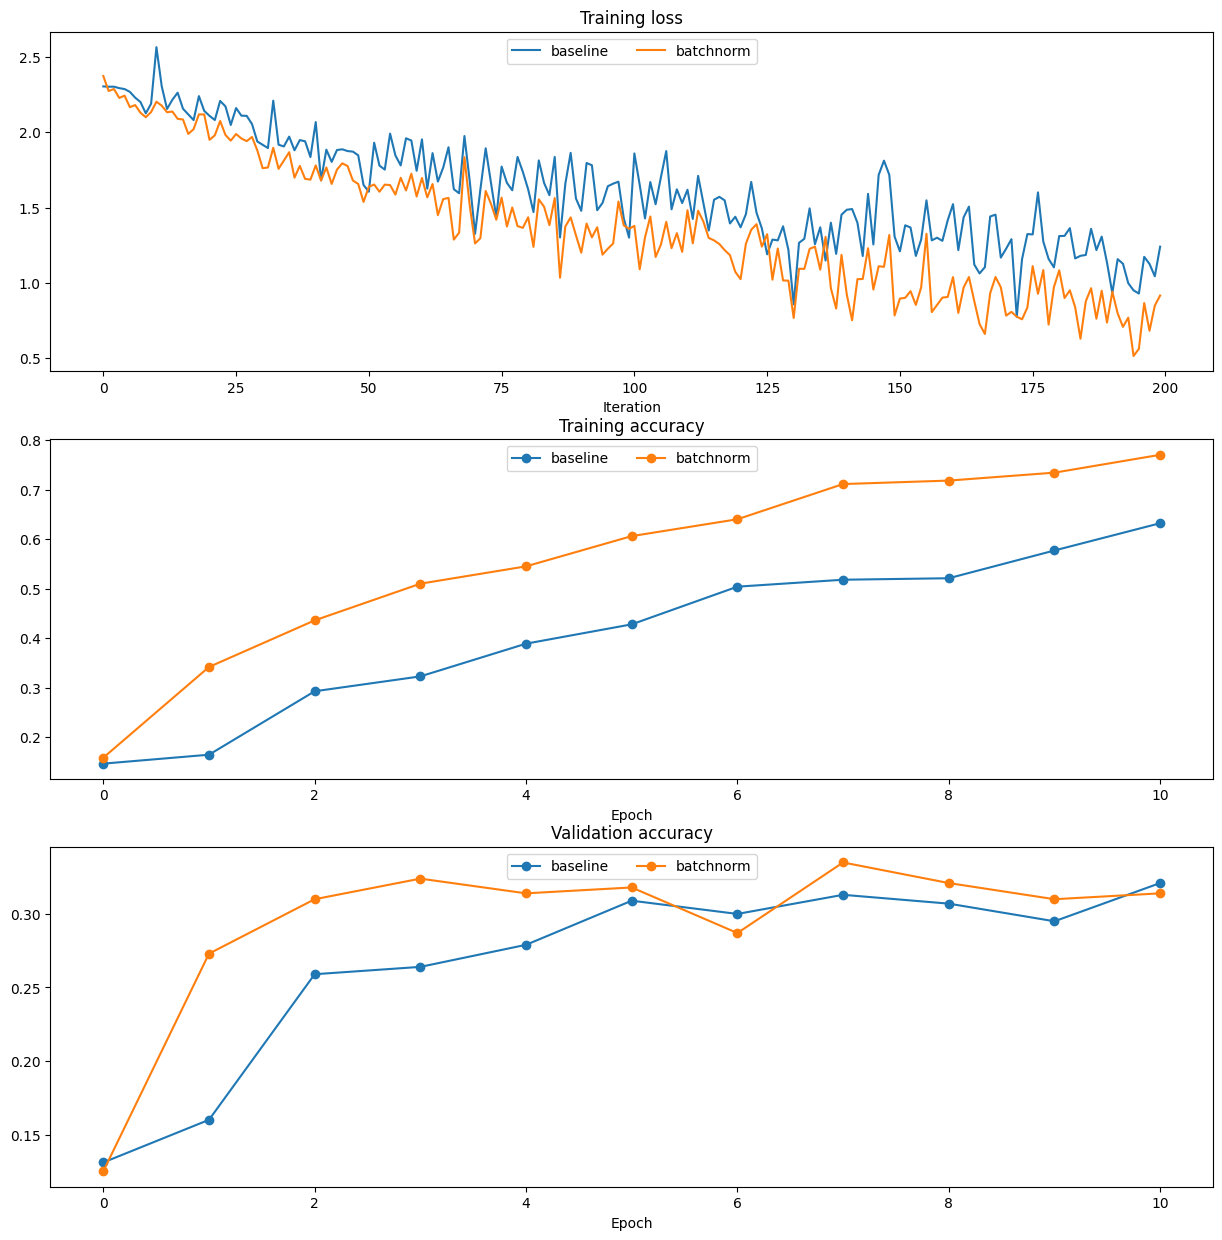

In [33]:
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(solver.loss_history, '-', label='baseline')
plt.plot(bn_solver.loss_history, '-', label='batchnorm')

plt.subplot(3, 1, 2)
plt.plot(solver.train_acc_history, '-o', label='baseline')
plt.plot(bn_solver.train_acc_history, '-o', label='batchnorm')

plt.subplot(3, 1, 3)
plt.plot(solver.val_acc_history, '-o', label='baseline')
plt.plot(bn_solver.val_acc_history, '-o', label='batchnorm')

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

solver.record_histories_as_npz('submission_logs/compare_bn_deep_networks_no_bn.npz')
bn_solver.record_histories_as_npz('submission_logs/compare_bn_deep_networks_with_bn.npz')

## Batch normalization and initialization
A small experiment to study the interaction of batch normalization and weight initialization.

In [34]:
# Try training a very deep net with batchnorm
hidden_dims = [50, 50, 50, 50, 50, 50, 50]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers = {}
solvers = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
    print ('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
    bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

    np.random.seed(seed)
    bn_solver = Solver(bn_model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
    bn_solver.train()
    bn_solvers[weight_scale] = bn_solver

    np.random.seed(seed)
    solver = Solver(model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
    solver.train()
    solvers[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20
Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


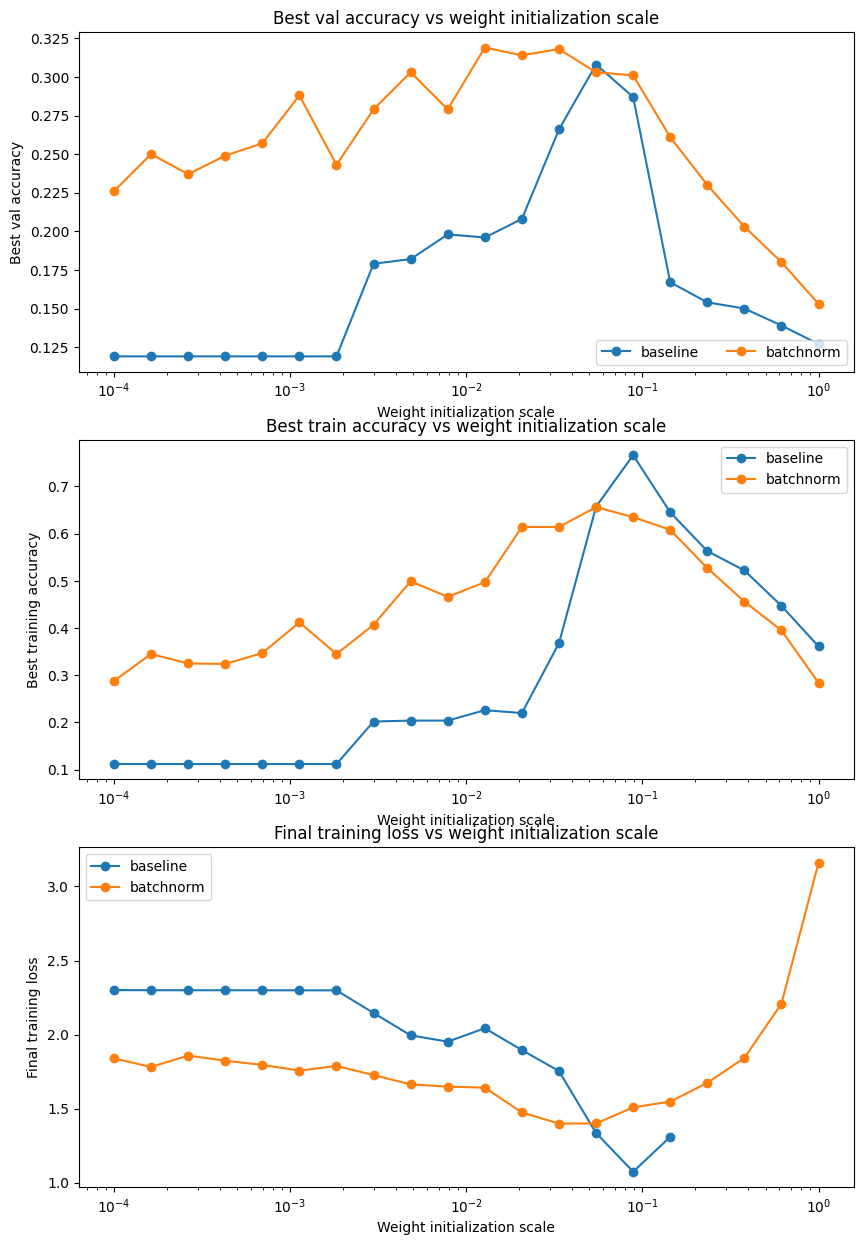

In [35]:
# Plot results of weight scale experiment
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for i, ws in enumerate(weight_scales):
    best_train_accs.append(max(solvers[ws].train_acc_history))
    bn_best_train_accs.append(max(bn_solvers[ws].train_acc_history))

    best_val_accs.append(max(solvers[ws].val_acc_history))
    bn_best_val_accs.append(max(bn_solvers[ws].val_acc_history))

    final_train_loss.append(np.mean(solvers[ws].loss_history[-100:]))
    bn_final_train_loss.append(np.mean(bn_solvers[ws].loss_history[-100:]))


    solvers[ws].record_histories_as_npz('submission_logs/bn_and_weight_scale_experiments_scale{}_no_bn.npz'.format(i))
    bn_solvers[ws].record_histories_as_npz('submission_logs/bn_and_weight_scale_experiments_scale{}_with_bn.npz'.format(i))

plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()

plt.gcf().set_size_inches(10, 15)
plt.show()

Batch Normalization intuitively helps mitigate the effects of bad initialization.

# Dropout


## Dropout forward pass
Implementation can be found in the file `deeplearning/layers.py`.
The following cell tests implementation.

In [23]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print ('Running tests with p = ', p)
    print ('Mean of input: ', x.mean())
    # expected: (approx.) 10, 10, 10
    print ('Mean of train-time output: ', out.mean())
    # expected: (approx.) 10, 10, 10
    print ('Mean of test-time output: ', out_test.mean())
    # expected: (approx.) 10, 10, 10
    print ('Fraction of train-time output set to zero: ', (out == 0).mean())
    # expected: (approx.) 0.3, 0.6, 0.75
    print ('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    # expected: (approx.) 0.0, 0.0, 0.0

Running tests with p =  0.3
Mean of input:  9.998789853577627
Mean of train-time output:  10.020247631749559
Mean of test-time output:  9.998789853577627
Fraction of train-time output set to zero:  0.699464
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.6
Mean of input:  9.998789853577627
Mean of train-time output:  9.999076070465984
Mean of test-time output:  9.998789853577627
Fraction of train-time output set to zero:  0.400036
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.75
Mean of input:  9.998789853577627
Mean of train-time output:  9.987496816443322
Mean of test-time output:  9.998789853577627
Fraction of train-time output set to zero:  0.250848
Fraction of test-time output set to zero:  0.0


## Dropout backward pass
Implementation can be found in the file `deeplearning/layers.py`.
The following cell tests  implementation.

In [24]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print ('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.4456058135296735e-11


## Fully-connected nets with Dropout
Implementation for batch normalization inside the FNC is in `deeplearning/classifiers/fc_net.py`. 
I defined additional helper layers in the file `deeplearning/layer_utils.py`.

In [25]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
    print ('Running check with dropout = ', dropout)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)
    loss, grads = model.loss(X, y)
    print ('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print ('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    print

Running check with dropout =  0
Initial loss:  2.3051948273987857
W1 relative error: 2.53e-07
W2 relative error: 1.50e-05
W3 relative error: 2.75e-07
b1 relative error: 2.94e-06
b2 relative error: 5.05e-08
b3 relative error: 1.17e-10
Running check with dropout =  0.25
Initial loss:  2.302393230564104
W1 relative error: 3.39e-07
W2 relative error: 2.24e-07
W3 relative error: 1.97e-07
b1 relative error: 3.68e-08
b2 relative error: 5.47e-09
b3 relative error: 7.54e-11
Running check with dropout =  0.5
Initial loss:  2.3013464380943134
W1 relative error: 1.29e-07
W2 relative error: 3.95e-07
W3 relative error: 4.28e-07
b1 relative error: 6.99e-09
b2 relative error: 2.82e-09
b3 relative error: 8.93e-11


## Regularization experiment
As an experiment, we will train a pair of two-layer networks on 500 training examples: one will use no dropout, and one will use a dropout probability of 0.5. We will then visualize the training and validation accuracies of the two networks over time.

In [37]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.5]
for dropout in dropout_choices:
    model = FullyConnectedNet([500], dropout=dropout)
    print (dropout)
    np.random.seed(seed)
    solver = Solver(model, small_data,
                  num_epochs=15, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=1)
    solver.train()
    solvers[dropout] = solver

0
(Iteration 1 / 75) loss: 7.565303
(Epoch 0 / 15) train acc: 0.234000; val_acc: 0.195000
(Iteration 2 / 75) loss: inf
(Iteration 3 / 75) loss: inf
(Iteration 4 / 75) loss: 16.740698
(Iteration 5 / 75) loss: inf
(Epoch 1 / 15) train acc: 0.310000; val_acc: 0.205000
(Iteration 6 / 75) loss: 15.983622
(Iteration 7 / 75) loss: inf
(Iteration 8 / 75) loss: 12.014031
(Iteration 9 / 75) loss: 11.402264
(Iteration 10 / 75) loss: inf
(Epoch 2 / 15) train acc: 0.492000; val_acc: 0.269000
(Iteration 11 / 75) loss: 7.079946
(Iteration 12 / 75) loss: 8.208239
(Iteration 13 / 75) loss: 10.169429
(Iteration 14 / 75) loss: inf
(Iteration 15 / 75) loss: 6.238055
(Epoch 3 / 15) train acc: 0.578000; val_acc: 0.283000
(Iteration 16 / 75) loss: 6.500657
(Iteration 17 / 75) loss: 5.036010
(Iteration 18 / 75) loss: 5.633551
(Iteration 19 / 75) loss: 4.318835
(Iteration 20 / 75) loss: 6.512596
(Epoch 4 / 15) train acc: 0.642000; val_acc: 0.287000
(Iteration 21 / 75) loss: 6.060894
(Iteration 22 / 75) loss: 4

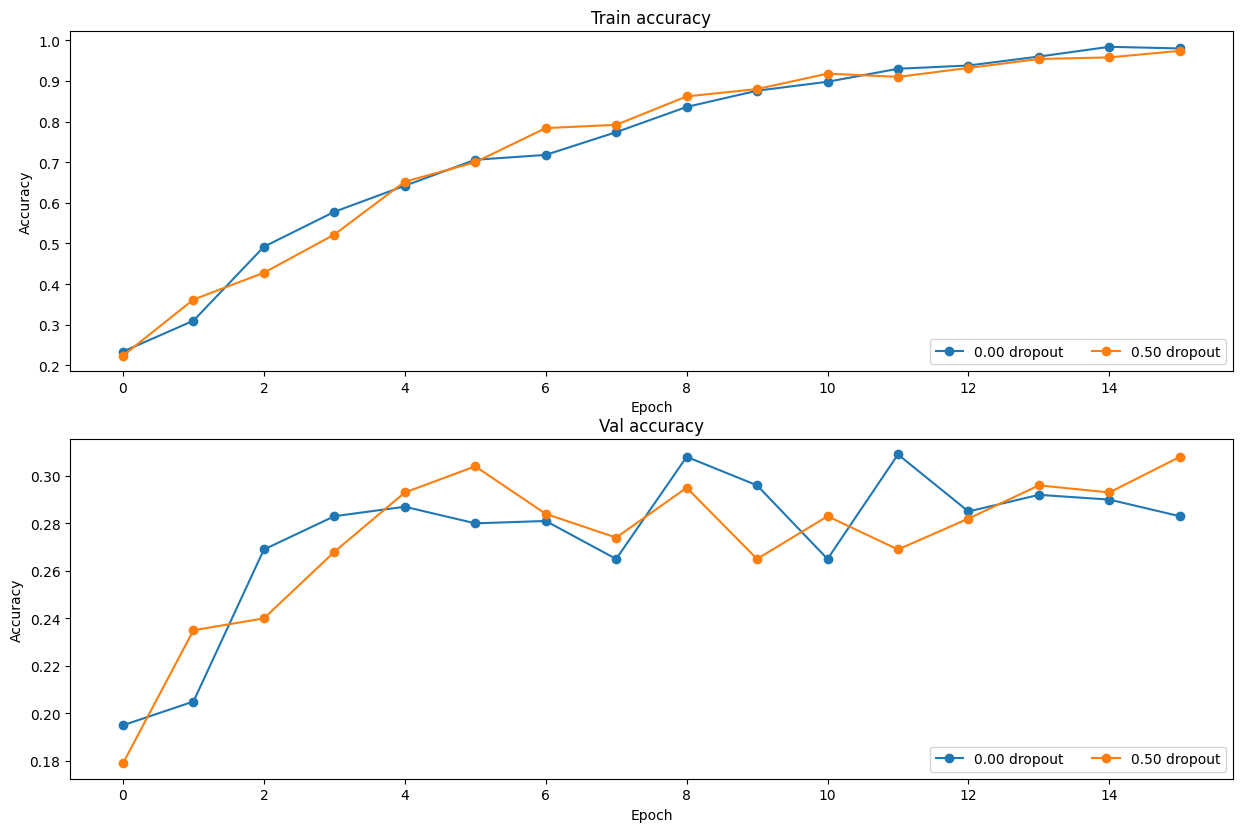

In [38]:
# Plot train and validation accuracies of the two models
train_accs = []
val_accs = []
for dropout in dropout_choices:
    solver = solvers[dropout]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])
    solver.record_histories_as_npz('submission_logs/dropout_regularization_experiment_p{}.npz'.format(dropout))

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].train_acc_history, '-o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].val_acc_history, '-o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

Dropout helps with the regularization of the optimization, we have a higher validation score as epochs increase, and it reduces the gap between the validation accuracy and the training accuracy, sure signs of better generalization.